In [1]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Specify each path

In [2]:
dataset = 'model/keypoint.csv'
model_save_path = 'model/aslr_model.hdf5'
tflite_save_path = 'model/aslr_model.tflite'

# Set number of classes

In [3]:
NUM_CLASSES = 24

# Dataset reading

In [4]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [5]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [7]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [8]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 42)                0         
                                                                 
 dense (Dense)               (None, 20)                860       
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 24)                264       
                                                                 
Total params: 1,334
Trainable params: 1,334
Non-trainable params: 0
_________________________________________________________________


In [9]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [10]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [11]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
1/8 [==>...........................] - ETA: 6s - loss: 3.2876 - accuracy: 0.0625
Epoch 1: saving model to model\aslr_model.hdf5
8/8 [==============================] - 1s 43ms/step - loss: 3.3031 - accuracy: 0.0514 - val_loss: 3.1675 - val_accuracy: 0.0769
Epoch 2/1000
1/8 [==>...........................] - ETA: 0s - loss: 3.2969 - accuracy: 0.0625
Epoch 2: saving model to model\aslr_model.hdf5
8/8 [==============================] - 0s 11ms/step - loss: 3.2320 - accuracy: 0.0568 - val_loss: 3.1405 - val_accuracy: 0.0865
Epoch 3/1000
1/8 [==>...........................] - ETA: 0s - loss: 3.1992 - accuracy: 0.0781
Epoch 3: saving model to model\aslr_model.hdf5
8/8 [==============================] - 0s 13ms/step - loss: 3.1972 - accuracy: 0.0718 - val_loss: 3.1292 - val_accuracy: 0.1026
Epoch 4/1000
1/8 [==>...........................] - ETA: 0s - loss: 3.1522 - accuracy: 0.0625
Epoch 4: saving model to model\aslr_model.hdf5
8/8 [==============================] - 0s 14ms/step 

In [12]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

3/3 [==============================] - 0s 3ms/step - loss: 0.8216 - accuracy: 0.7949


In [13]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [14]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 112ms/step
[5.31274046e-16 5.80020104e-29 4.23112133e-21 5.59888249e-17
 3.06376550e-28 9.83447769e-18 1.70010435e-21 5.24854904e-21
 1.86721002e-17 1.97998343e-25 4.50707555e-16 2.08719721e-34
 1.54857294e-26 1.11280869e-23 2.75110942e-04 9.99724925e-01
 1.12280955e-20 2.06780574e-18 1.02709799e-29 2.74641502e-13
 7.33691088e-18 6.50388829e-33 6.58129888e-28 7.93497375e-13]
15


# Confusion matrix

10/10 [==============================] - 0s 1ms/step


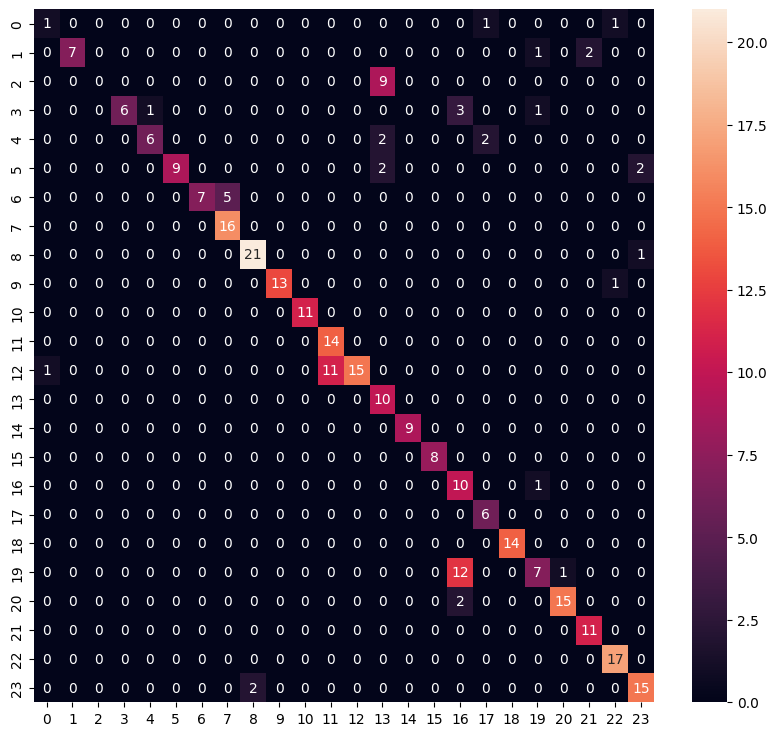

Classification Report
              precision    recall  f1-score   support

           0       0.50      0.33      0.40         3
           1       1.00      0.70      0.82        10
           2       0.00      0.00      0.00         9
           3       1.00      0.55      0.71        11
           4       0.86      0.60      0.71        10
           5       1.00      0.69      0.82        13
           6       1.00      0.58      0.74        12
           7       0.76      1.00      0.86        16
           8       0.91      0.95      0.93        22
           9       1.00      0.93      0.96        14
          10       1.00      1.00      1.00        11
          11       0.56      1.00      0.72        14
          12       1.00      0.56      0.71        27
          13       0.43      1.00      0.61        10
          14       1.00      1.00      1.00         9
          15       1.00      1.00      1.00         8
          16       0.37      0.91      0.53        11
     

c:\Dev\Project\SignLanguageRegognition\env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Dev\Project\SignLanguageRegognition\env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Dev\Project\SignLanguageRegognition\env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(10, 9))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [16]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [17]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\Sam\AppData\Local\Temp\tmpzzk5o6e0\assets


INFO:tensorflow:Assets written to: C:\Users\Sam\AppData\Local\Temp\tmpzzk5o6e0\assets


7424

# Inference test

In [18]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [19]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [20]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [21]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 15.6 ms
Wall time: 998 µs


In [22]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[5.31276058e-16 5.80020044e-29 4.23113748e-21 5.59888249e-17
 3.06376550e-28 9.83451491e-18 1.70011082e-21 5.24856923e-21
 1.86721018e-17 1.97999847e-25 4.50707555e-16 2.08721305e-34
 1.54857848e-26 1.11281705e-23 2.75111437e-04 9.99724925e-01
 1.12280947e-20 2.06781360e-18 1.02709791e-29 2.74642017e-13
 7.33693818e-18 6.50393751e-33 6.58129840e-28 7.93498839e-13]
15
